importing necessary libraries

In [148]:
## Data loading, processing 
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Visualization
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.ensemble import VotingClassifier




In the first row we can see 9 features and a target column.

The feature columms are :

Step: This feature represents the day from the start of simulation. It has 180 steps so simulation ran for virtually 6 months.

Customer: represents the customer id

zipCodeOrigin: The zip code of origin/source.

Merchant: The merchant's id

zipMerchant: The merchant's zip code

Age: Categorized age
0: <= 18,
1: 19-25,
2: 26-35,
3: 36-45,
4: 46:55,
5: 56:65,
6: > 65
U: Unknown

Gender: Gender for customer

E : Enterprise,
M: Male,
F: Female,
U: Unknown

Category: Category of the purchase.

Amount: Amount of the purchase

Fraud: Target which shows if the transaction fraudulent(1) or benign(0)

In [149]:
# read the dataset and show the first 10 rows
data_request = pd.read_csv("data/bs140513_032310.csv")
df = pd.DataFrame(data_request)
data_request.head(10)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0
5,0,'C1315400589','3','F','28007','M348934600','28007','es_transportation',25.81,0
6,0,'C765155274','1','F','28007','M348934600','28007','es_transportation',9.10,0
7,0,'C202531238','4','F','28007','M348934600','28007','es_transportation',21.17,0
8,0,'C105845174','3','M','28007','M348934600','28007','es_transportation',32.40,0
9,0,'C39858251','5','F','28007','M348934600','28007','es_transportation',35.40,0


The information about the data
Because it's columns are non-null we don't expect null values in the dataset.

In [150]:
data_request.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


Fraud data is often imbalanced, as shown in the plot and the instance counts.

To balance the dataset, we can use oversampling or undersampling techniques. 

Oversampling involves increasing the number of instances in the minority class by generating new instances, while undersampling reduces the number of instances in the majority class by randomly selecting points until it matches the minority class. 

Both methods have their risks: 

oversampling can create duplicate or similar data points, which may not be effective for fraud detection due to the variability in fraudulent transactions, and undersampling can lead to loss of data and information. 

We will use an oversampling technique called SMOTE (Synthetic Minority Over-sampling Technique), which generates new data points for the minority class using neighboring instances, ensuring the new samples are not exact copies but are similar to the existing ones.

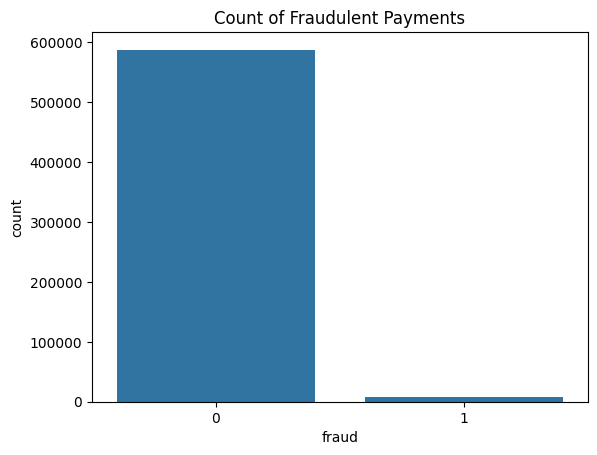

# normal examples:  587443
# fradulent examples:  7200


In [151]:
# 2 dataframes for fraud and non-fraud data 
df_nfraud = data_request.loc[data_request.fraud == 0]
df_fraud = data_request.loc[data_request.fraud == 1] 


sb.countplot(x="fraud",data=data_request)
plt.title("Count of Fraudulent Payments")
plt.show()
print("# normal examples: ",df_nfraud.fraud.count())
print("# fradulent examples: ",df_fraud.fraud.count())



 you can see the mean of amount of purchases and number of fraud payments in each category.
 It appears that leisure and travel are the top categories targeted by fraudsters. 
 
  Fraudsters seem to prefer categories where average spending is higher. To validate this hypothesis, let's examine the transaction amounts for both fraud and non-fraud transactions.

In [152]:

# Group by 'category' and aggregate 'amount', 'fraud', and count the number of transactions
grouped_df = df.groupby('category').agg(
    mean_amount=('amount', 'mean'),
    sum_fraud=('fraud', 'sum'),
    total_transactions=('step', 'count')
)
print(grouped_df)



                         mean_amount  sum_fraud  total_transactions
category                                                           
'es_barsandrestaurants'    43.461014        120                6373
'es_contents'              44.547571          0                 885
'es_fashion'               65.666642        116                6454
'es_food'                  37.070405          0               26254
'es_health'               135.621367       1696               16133
'es_home'                 165.670846        302                1986
'es_hotelservices'        205.614249        548                1744
'es_hyper'                 45.970421        280                6098
'es_leisure'              288.911303        474                 499
'es_otherservices'        135.881524        228                 912
'es_sportsandtoys'        215.715280       1982                4002
'es_tech'                 120.947937        158                2370
'es_transportation'        26.958187          0 

we can see the pecentage of fraudulant transactions in each category in the below table.

In [153]:
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_nfraud.groupby('category')['amount'].mean(),\
           data_request.groupby('category')['fraud'].mean()*100],keys=["Fraud","Non-Fraud","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Percent(%)'], ascending= False)

,Fraud,Non-Fraud,Percent(%)
category,,,
'es_leisure',300.286878,73.230400,94.989980
'es_travel',2660.802872,669.025533,79.395604
'es_sportsandtoys',345.366811,88.502738,49.525237
'es_hotelservices',421.823339,106.548545,31.422018
'es_otherservices',316.469605,75.685497,25.000000
'es_home',457.484834,113.338409,15.206445
'es_health',407.031338,103.737228,10.512614
'es_tech',415.274114,99.924638,6.666667
'es_wellnessandbeauty',229.422535,57.320219,4.759380


 in all the categories the average amount spend are similar; it's between 0-500 discarding the outliers, except for the travel category that average is very high.



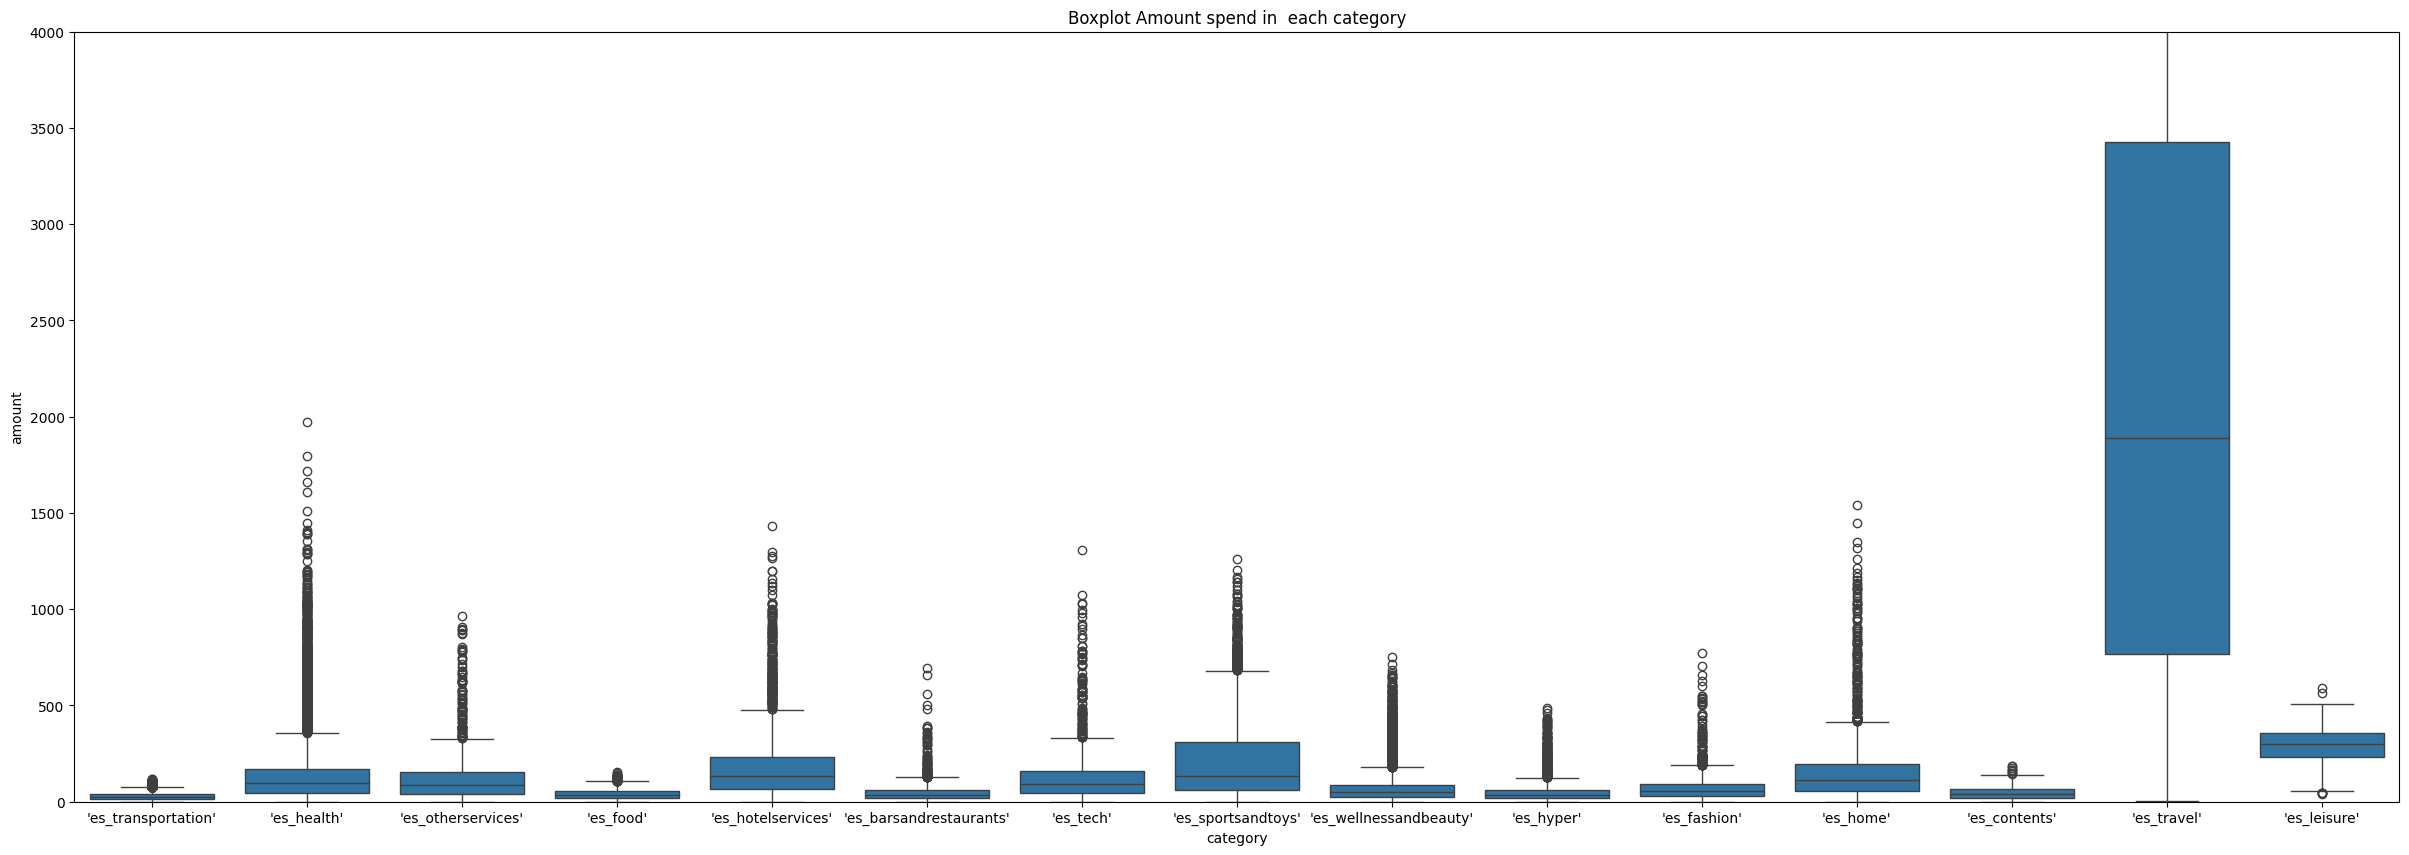

In [154]:


# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sb.boxplot(x=data_request.category,y=data_request.amount)
plt.title("Boxplot Amount spend in  each category")
plt.ylim(0,4000)
plt.show()

In the histogram below, we can see the fradulent transactions are less in count but more in amount.

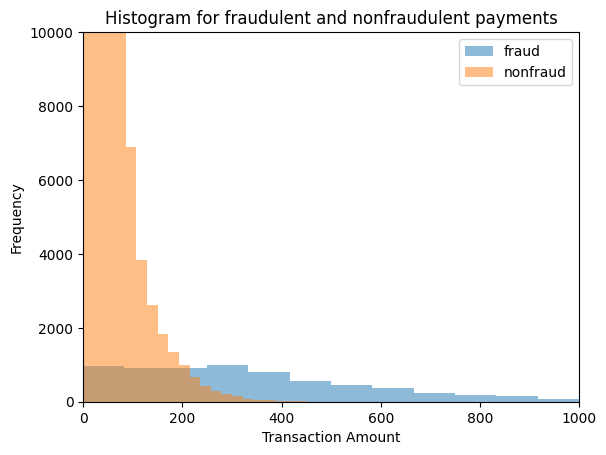

In [155]:

# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud', bins=100)
plt.hist(df_nfraud.amount, alpha=0.5, label='nonfraud', bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.ylim(0, 10000)
plt.xlim(0, 1000)
plt.legend()
plt.show()

In the below table you can see in the Age category of "0", the probability of fraud is more. Maybe the fraudsters thinking its less consequences if they show their age under 18.

In [156]:

# Calculate the mean fraud percentage
fraud_percent = data_request.groupby('age')['fraud'].mean() * 100

# Count the number of frauds and non-frauds
fraud_counts = data_request[data_request['fraud'] == 1].groupby('age').size().reset_index(name='Number of Frauds')
non_fraud_counts = data_request[data_request['fraud'] == 0].groupby('age').size().reset_index(name='Number of Non-Frauds')

# Merge the counts with the fraud percentage
result = fraud_percent.reset_index().rename(columns={'age': 'Age', 'fraud': 'Fraud Percent'})
fraud_counts = fraud_counts.rename(columns={'age': 'Age'})
non_fraud_counts = non_fraud_counts.rename(columns={'age': 'Age'})

result = result.merge(fraud_counts, on='Age', how='left').merge(non_fraud_counts, on='Age', how='left')

# Sort by Fraud Percent
result = result.sort_values(by='Fraud Percent')

print(result)

   Age  Fraud Percent  Number of Frauds  Number of Non-Frauds
7  'U'       0.594228                 7                  1171
6  '6'       0.974826               261                 26513
5  '5'       1.095112               686                 61956
1  '1'       1.185254               689                 57442
3  '3'       1.192815              1755                145376
2  '2'       1.251401              2344                184966
4  '4'       1.293281              1410                107615
0  '0'       1.957586                48                  2404


I drop 1 fraud data and 1 non_fraud data from dataset for testiog in my web service. I store these data in request.json 

In [157]:

# find first fraud data 
first_fraud = data_request[data_request['fraud'] == 1].iloc[[0]]
# find first nonfraud data 
first_non_fraud = data_request[data_request['fraud'] == 0].iloc[[0]]

separated_samples = pd.concat([first_fraud, first_non_fraud])

# drop from dataset
data_request = data_request.drop(separated_samples.index)

print(separated_samples)

    step       customer  age gender zipcodeOri      merchant zipMerchant  \
88     0   'C583110837'  '3'    'M'    '28007'  'M480139044'     '28007'   
0      0  'C1093826151'  '4'    'M'    '28007'  'M348934600'     '28007'   

               category  amount  fraud  
88          'es_health'   44.26      1  
0   'es_transportation'    4.55      0  


# Data Preprocessing
In this part we will preprocess and prepare the data for the training.

In [158]:
print("Unique values of zipMerchant : ",data_request.zipMerchant.nunique())
print("Unique values of zipCodeOri : ",data_request.zipcodeOri.nunique())

# dropping zipcodeori, zipMerchant and customer
reduced_data = data_request.drop(['zipMerchant','zipcodeOri','customer'],axis=1)

Unique values of zipMerchant :  1
Unique values of zipCodeOri :  1


columns after reducing

In [159]:
print(reduced_data.columns)


Index(['step', 'age', 'gender', 'merchant', 'category', 'amount', 'fraud'], dtype='object')



To convert categorical features into numerical values, it's often preferable to use dummy variables since categorical values don't have an inherent order (e.g., customer1 isn't greater than customer2).
 However, with over 500,000 customers and merchants, creating dummy variables would result in a feature set of size (10^5), making the training process extremely slow. Below is the code to transform categorical features into numerical values.

In [160]:

import json 
# Load mappings from JSON file
with open('json/mappings.json', 'r') as f:
    mappings = json.load(f)

category_mapping = mappings['category_mapping']
merchant_mapping = mappings['merchant_mapping']
gender_mapping = mappings['gender_mapping']

# Remove extra quotes from DataFrame values
reduced_data['category'] = reduced_data['category'].str.replace("'", "", regex=False)
reduced_data['merchant'] = reduced_data['merchant'].str.replace("'", "", regex=False)
reduced_data['gender'] = reduced_data['gender'].str.replace("'", "", regex=False)
reduced_data['age'] = reduced_data['age'].str.replace("'", "", regex=False)
reduced_data['age'] = reduced_data['age'].str.replace("U", "7", regex=False)
reduced_data['age'] = reduced_data['age'].astype('Int64')
reduced_data['amount'] = np.ceil(reduced_data['amount']).astype('int64')


# Apply mappings
reduced_data['category'] = reduced_data['category'].map(category_mapping)
reduced_data['merchant'] = reduced_data['merchant'].map(merchant_mapping)
reduced_data['gender'] = reduced_data['gender'].map(gender_mapping)

reduced_data.head(20)



,step,age,gender,merchant,category,amount,fraud
1,0,2,1,0,12,40,0
2,0,4,0,1,12,27,0
3,0,3,1,0,12,18,0
4,0,5,1,0,12,36,0
5,0,3,0,0,12,26,0
6,0,1,0,0,12,10,0
7,0,4,0,0,12,22,0
8,0,3,1,0,12,33,0
9,0,5,0,0,12,36,0
10,0,4,0,0,12,15,0


In [161]:
X = reduced_data.drop(['fraud'], axis=1).astype('float64')
y = reduced_data['fraud']
print(X.head(5),"\n")
print(y.head(5))
y[y==1].count()


   step  age  gender  merchant  category  amount
1   0.0  2.0     1.0       0.0      12.0    40.0
2   0.0  4.0     0.0       1.0      12.0    27.0
3   0.0  3.0     1.0       0.0      12.0    18.0
4   0.0  5.0     1.0       0.0      12.0    36.0
5   0.0  3.0     0.0       0.0      12.0    26.0 

1    0
2    0
3    0
4    0
5    0
Name: fraud, dtype: int64


7199

# Oversampling with SMOTE

for balancing the dataset, SMOTE(Synthetic Minority Oversampling Technique) is used. In the result we can see the count of both classes(fraud and nonFraud) are the same.

In [162]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)

# Convert columns back to int64 after SMOTE
X_res = X_res.round().astype('int64')
y_res = y_res.astype('int64')

print(y_res['fraud'].value_counts())

fraud
0    587442
1    587442
Name: count, dtype: int64


Train test split for measuring the performance.

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)


plotting the ROC_AUC curve. For seeing the classification performance, the ROC_AUC curve is a good visual way.
This function takes the actual values and predicted probabilities as input and plots the Receiver Operating Characteristic (ROC) curve.


In [164]:

def plot_roc_auc(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)  # Calculate false positive rate and true positive rate
    roc_auc = auc(fpr, tpr)  # Compute the area under the ROC curve
    plt.title('Receiver Operating Characteristic') 
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)  # Plot the ROC curve with AUC label
    plt.legend(loc='lower right') 
    plt.plot([0, 1], [0, 1], 'r--')  # Plot a diagonal line for reference
    plt.xlim([0, 1])  
    plt.ylim([0, 1]) 
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate') 
    plt.show()  


def report_func(y_prediction, model_name):
    print("Classification Report: \n", )
    report = classification_report(y_test, y_prediction, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)



    #confusion matrix
    print("confusion matrix: \n", )
    conf_matrix = confusion_matrix(y_test, y_prediction)
    plt.figure(figsize=(10, 7))
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix of {model_name}: \n')
    plt.show()
    


As mentioned earlier, fraud datasets are typically imbalanced, with the majority of instances being non-fraudulent. If we were to always predict non-fraudulent cases, our accuracy would be nearly 99% for this dataset and similar ones, given the low percentage of fraud cases. Although our accuracy appears high, we wouldn't be detecting any frauds, rendering the classifier ineffective. Therefore, the baseline accuracy should be higher than simply predicting non-fraudulent cases to effectively detect fraud.

In [165]:

# Calculate the base accuracy score by dividing the number of non-fraudulent cases by the total number of cases (both non-fraudulent and fraudulent), then multiply by 100 to get the percentage.
print("Base accuracy score: ", 
df_nfraud.fraud.count() / (df_nfraud.fraud.count() + df_fraud.fraud.count()) * 100)

Base accuracy score:  98.7891894800746


# K-Nearest Neighbors classifier
This code initializes a K-Nearest Neighbors classifier, trains it on the training data, and makes predictions on the test data. It then prints the classification report and confusion matrix, and plots the ROC curve using the predicted probabilities.

c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K-Nearest Neighbours Reports:

Classification Report: 

              precision    recall  f1-score        support
0              0.999735  0.985190  0.992409  176233.000000
1              0.985402  0.999739  0.992519  176233.000000
accuracy       0.992465  0.992465  0.992465       0.992465
macro avg      0.992569  0.992465  0.992464  352466.000000
weighted avg   0.992569  0.992465  0.992464  352466.000000
confusion matrix: 



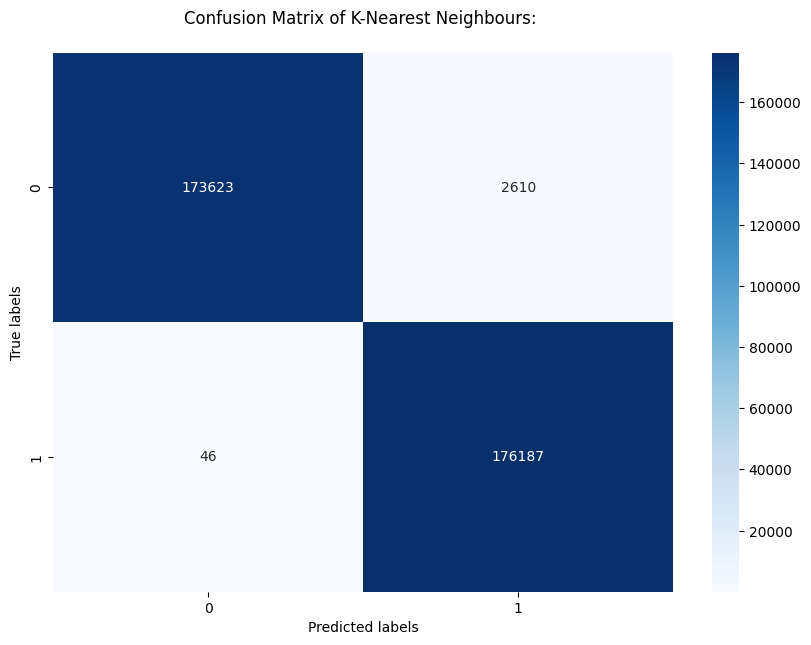

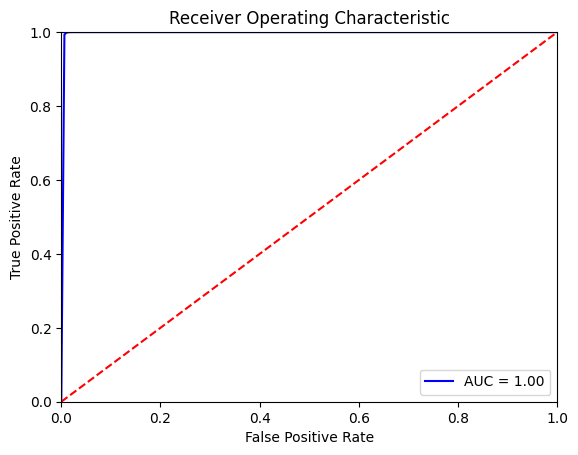

In [166]:

knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_prediction = knn.predict(X_test)
print("K-Nearest Neighbours Reports:\n")
report_func(y_prediction, "K-Nearest Neighbours")
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])



# Random Forest Classifier


c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   47.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


Classification Report: 

              precision    recall  f1-score        support
0              0.994737  0.966221  0.980271  176233.000000
1              0.967162  0.994887  0.980829  176233.000000
accuracy       0.980554  0.980554  0.980554       0.980554
macro avg      0.980949  0.980554  0.980550  352466.000000
weighted avg   0.980949  0.980554  0.980550  352466.000000
confusion matrix: 



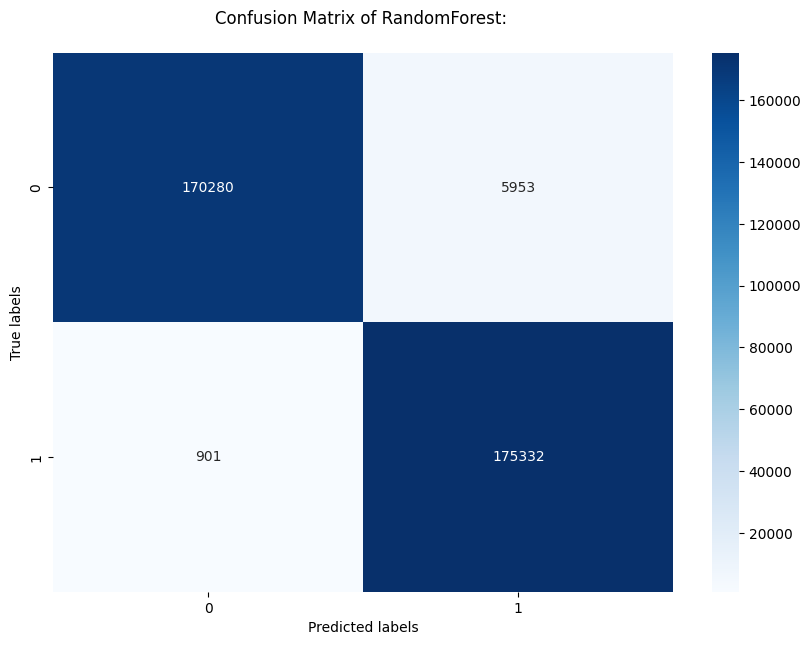

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


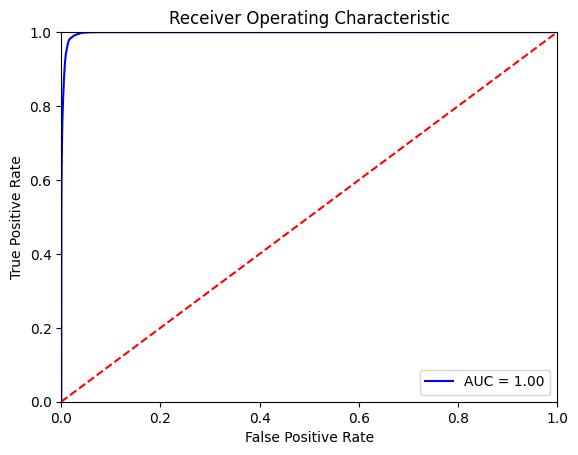

In [167]:

# Initialize the Random Forest classifier with 200 estimators, a maximum depth of 8, and balanced class weights
rf_clf = RandomForestClassifier(n_estimators=100 , max_depth=8, random_state=42,
verbose=1, class_weight="balanced")

# Train the classifier using the training data
rf_clf.fit(X_train, y_train)

# Predict the labels for the test data
y_prediction = rf_clf.predict(X_test)

report_func(y_prediction, "RandomForest")
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])


# XGBoost Classifier


c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [13:06:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report: 

              precision    recall  f1-score        support
0              0.993324  0.985292  0.989292  176233.000000
1              0.985410  0.993378  0.989378  176233.000000
accuracy       0.989335  0.989335  0.989335       0.989335
macro avg      0.989367  0.989335  0.989335  352466.000000
weighted avg   0.989367  0.989335  0.989335  352466.000000
confusion matrix: 



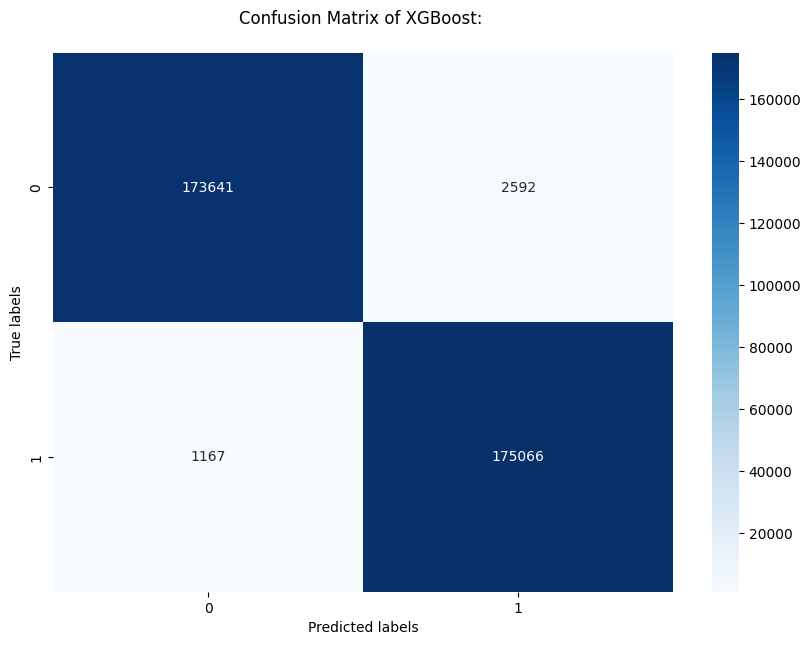

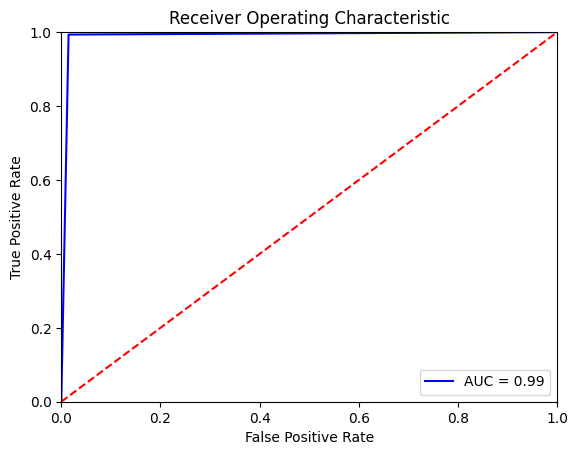

In [168]:
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)

XGBoost_CLF.fit(X_train,y_train)

# پیش‌بینی
y_prediction = XGBoost_CLF.predict(X_test)

# ارزیابی مدل
report_func(y_prediction, "XGBoost")
plot_roc_auc(y_test, y_prediction)

# Ensemble Model

c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   48.5s
c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [13:09:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  war

Classification Report: 

              precision    recall  f1-score        support
0              0.996803  0.983567  0.990141  176233.000000
1              0.983783  0.996845  0.990271  176233.000000
accuracy       0.990206  0.990206  0.990206       0.990206
macro avg      0.990293  0.990206  0.990206  352466.000000
weighted avg   0.990293  0.990206  0.990206  352466.000000
confusion matrix: 



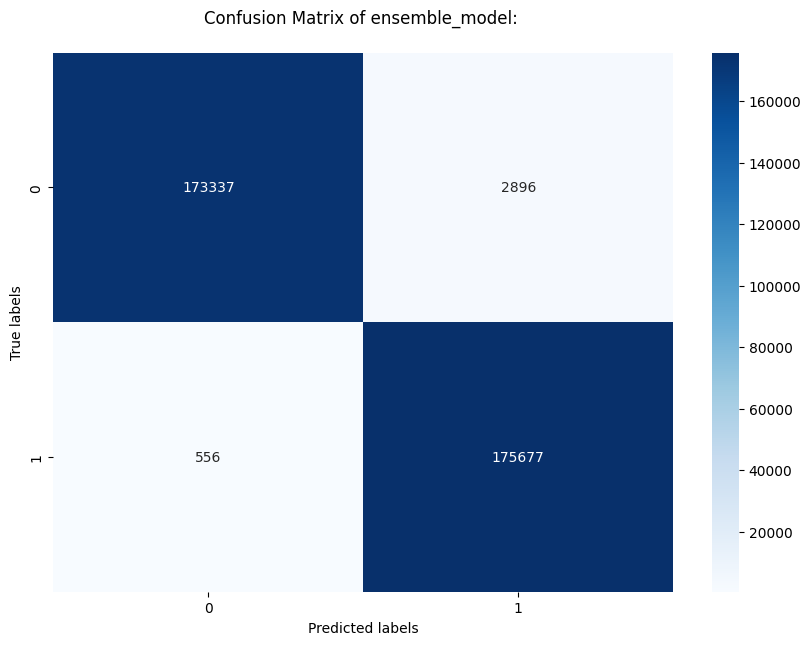

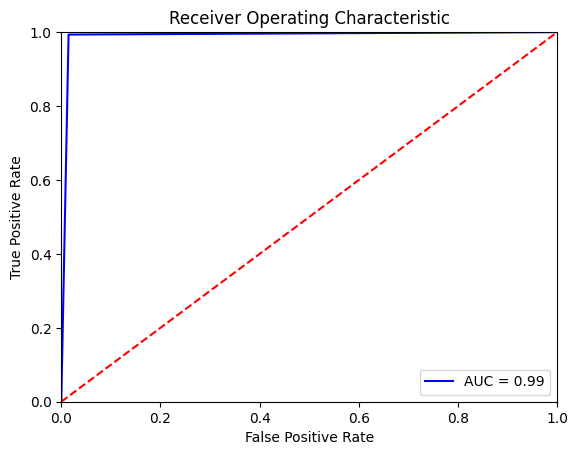

In [169]:
ensemble_model = VotingClassifier(estimators=[
    ('knn', knn),
    ('rf', rf_clf),
    ('xgb', XGBoost_CLF)
], voting='soft') 

ensemble_model.fit(X_train, y_train)

# Prediction with the ensemble model
y_prediction = ensemble_model.predict(X_test)

report_func(y_prediction, "ensemble_model")
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])
